<a href="https://colab.research.google.com/github/nshanbhag2003/Deep-Models-NLP-Reinforcement-Learning/blob/main/AML_IMDB_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN for IMDB review classification

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint # for prettier print when it comes to text

In [ ]:
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU is available.


 ## 1. Text classification via BoW and Logistic classifier

### a) Data exploration and processing

In [ ]:
import os, tarfile, urllib.request
# The following code downloads the data, extract the tar file into DATA_DIR
# if the folder has not yet been downloaded and extracted
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
DATA_DIR = "aclImdb" # Replace with your download folder

if not os.path.exists(DATA_DIR):
    print("Downloading IMDB dataset...")
    urllib.request.urlretrieve(url, "aclImdb_v1.tar.gz")

    print("Extracting...")
    with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as tar:
        tar.extractall()
    print("Done!")
else:
    print("IMDB dataset already exists.")

Extracting...


/tmp/ipython-input-2607231566.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Done!


In [ ]:
from pathlib import Path
# The following function helps you load the training and test data where each
# review is a single string vector with label 1 if positive, 0 otherwise
# We should be loading 25000 train and 25000 test reviews.

def load_imdb_split(split_dir):
    texts, labels = [], []
    for label_type in ["pos", "neg"]:
        dir_path = Path(split_dir)/label_type
        for file_path in dir_path.iterdir():
            with open(file_path, encoding="utf-8") as f:
                texts.append(f.read())
            labels.append(1 if label_type == "pos" else 0)
    return texts, labels

train_texts, train_labels = load_imdb_split(DATA_DIR + "/train")
test_texts, test_labels   = load_imdb_split(DATA_DIR + "/test")

print(f"Loaded {len(train_texts)} train and {len(test_texts)} test reviews.")

Loaded 25000 train and 25000 test reviews.


In [ ]:
# Display the first train review's first 500 characters
pprint(train_texts[0][:500])

('This was a very enjoyable film. A humorous, but poignant look at family, and '
 'the obligations that come with it. The story of a man who comes home from '
 'his life in the city to his fathers bath house in a small Chinese village. '
 'There he learns to appreciate, even cherish the very things he left home to '
 'get away from. The film is as visually beautiful as it is emotionally '
 'beautiful.')


### b. Bag of words

In [ ]:
import re, html, unicodedata
from sklearn.feature_extraction.text import CountVectorizer
# Here we give an example of steps one can take when cleaning text data before construction BoW
# basic_clean will be a custom function we can establish for specific cleaning steps. Here IMDB
# reviews are scrapped from the web page, the url and tag replacement steps can be crucial here
# depending on the downstream method

URL_RE   = re.compile(r'https?://\S+|www\.\S+')
TAG_RE   = re.compile(r'<[^>]+>')
NUM_RE   = re.compile(r'\b\d+([.,]\d+)*\b')
WS_RE    = re.compile(r'\s+')
APOSTROPHE_RE = re.compile(r"[’`´]")
CONTRACTIONS = {
    "can't": "can not", "won't": "will not", "n't": " not",
    "'re": " are", "'s": " is", "'d": " would", "'ll": " will", "'ve": " have", "'m": " am"
}

def basic_clean(text):
    text = html.unescape(text) # HTML entities & tags removal
    text = TAG_RE.sub(' ', text)
    def strip_accents(s):
      return ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
    text = strip_accents(text) #  normalize unicode & accents
    text = APOSTROPHE_RE.sub("'", text) # normalize apostrophes to plain '
    text = URL_RE.sub(' <url> ', text) # replace urls/emails/numbers with placeholders
    text = re.sub(r'\S+@\S+\.\S+', ' <email> ', text)
    text = NUM_RE.sub(' <num> ', text)
    for k, v in CONTRACTIONS.items(): #  expand contractions (eg negations)
        text = text.replace(k, v)
    text = re.sub(r"[^a-z0-9<> ]+", " ", text) #  remove punctuation (keep spaces and angle-bracket tokens)
    text = WS_RE.sub(' ', text).strip() # collapse whitespace
    return text

vectorizer = CountVectorizer(
    preprocessor = basic_clean, # pass the basic_clean function for custom processing
    tokenizer=None, # let sklearn do default tokenization
    lowercase=True, # convert text to lowercase
    stop_words='english', # stop_words='english' to drop common fillers
    min_df = 5, # ignore very rare terms
    max_df = 0.8, # ignore very common terms
    max_features=None, # if 600 f.e. would retain top 600 features
)

bow_train = vectorizer.fit_transform(train_texts) # cleaned vectorized train bow
vocabulary = vectorizer.get_feature_names_out() # get the vocabulary constructed from bow

In [ ]:
vocabulary[0:10]

array(['00s', '100th', '10s', '10th', '11th', '12', '12th', '13', '13th',
       '14'], dtype=object)

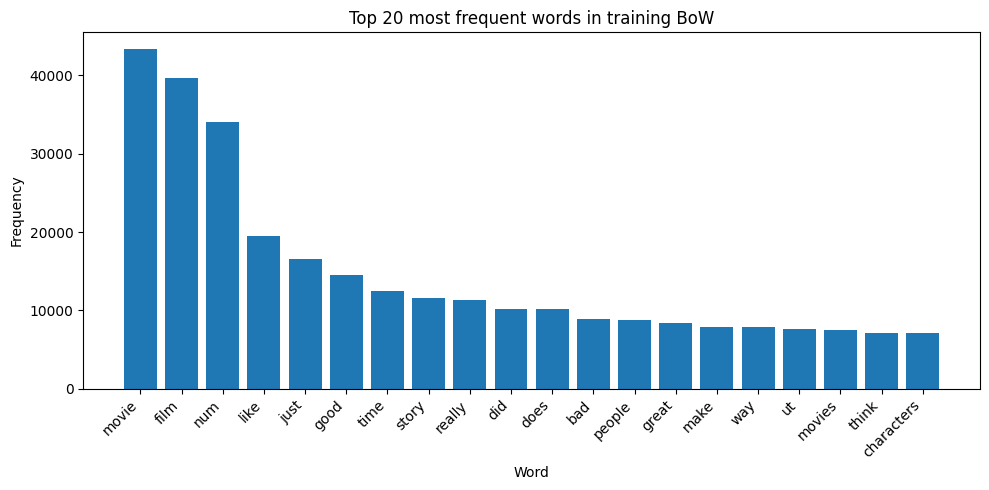

In [ ]:
word_freq = np.asarray(bow_train.sum(axis=0)).ravel()
sorted_idx = np.argsort(word_freq)[::-1]

N = 20
top_words = [vocabulary[i] for i in sorted_idx[:N]]
top_freqs = word_freq[sorted_idx[:N]]

plt.figure(figsize=(10,5))
plt.bar(top_words, top_freqs)
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 most frequent words in training BoW")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
from typing import List, Tuple
from torch.utils.data import Dataset, DataLoader

ROOT = Path(DATA_DIR)
TRAIN_FEAT = ROOT / "train" / "labeledBow.feat"
TEST_FEAT  = ROOT / "test"  / "labeledBow.feat"
VOCAB_FILE = ROOT / "imdb.vocab"
corpus = open(TRAIN_FEAT, encoding="utf-8").read().strip().splitlines()
with open(VOCAB_FILE, encoding="utf-8") as f:
    vocab = [line.strip() for line in f]
print(len(vocab))

89527


In [ ]:
print(corpus[0][:100])

9 0:9 1:1 2:4 3:4 4:6 5:4 6:2 7:2 8:4 10:4 12:2 26:1 27:1 28:1 29:2 32:1 41:1 45:1 47:1 50:1 54:2 57


In [ ]:
vocab[0:10]

['the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this']

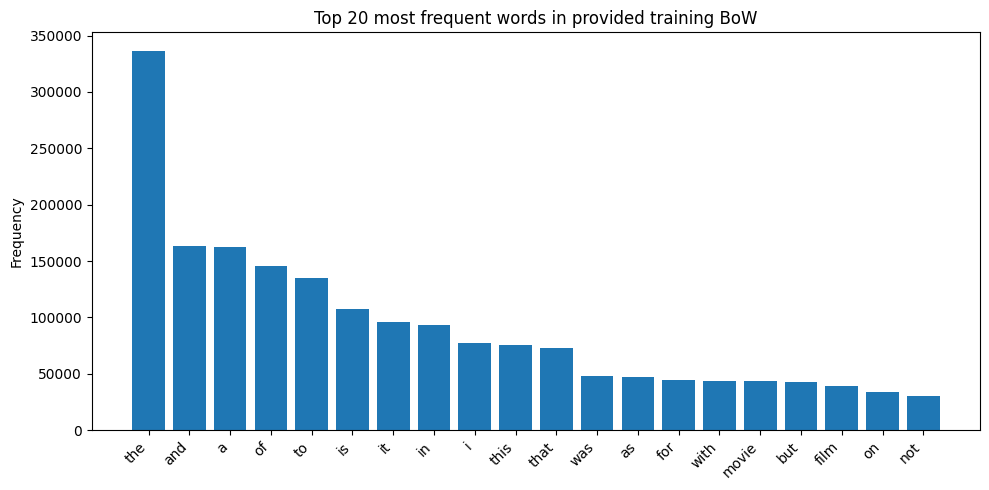

In [ ]:
vocab_size = len(vocab)
freq = np.zeros(vocab_size, dtype=np.float64)
for line in corpus:
    parts = line.split()
    for tok in parts[1:]:
        k, c = tok.split(":")
        idx = int(k)
        cnt = float(c)
        if 0 <= idx < vocab_size:
            freq[idx] += cnt

top_idx = np.argsort(freq)[-N:][::-1]  # largest to smallest
top_words = [vocab[i] for i in top_idx]
top_freqs = freq[top_idx]

plt.figure(figsize=(10, 5))
ypos = np.arange(len(top_words))[::-1]  # most frequent at top
plt.bar(ypos, top_freqs[::-1])
plt.xticks(ypos, top_words[::-1], rotation=45, ha='right')
plt.ylabel("Frequency")
plt.title(f"Top {N} most frequent words in provided training BoW")
plt.tight_layout()
plt.show()

### **Question 1a**
* How is a negative review defined in this dataset? Positive review? Can you explain how each `.txt` file is named?
* Can you explain the logic behind the encoding of the printed 100 characters of the first entry of `corpus`? In particular, what does it mean to see **x:y**? Note that the first element of `corpus[0]` is the rating corresponding to the review 0.
* Can you comment the difference in the top 20 most frequent words obtained via the sklearn `CountVectorizer` method and the provided BoW? Can you modify parameters in `CountVectorizer` to get more similar BoW distribution?
* What are the drawbacks of using BoW?

**Your answer**:

* In this dataset, a negative review is any review stored in the `neg` folder and labeled `0`, while a positive review is in the `pos` folder and labeled `1`. Each `.txt` file is named `<reviewID>_<rating>.txt`, where `reviewID` is unique and `rating` is the original IMDb score (typically 1–4 for negative, 7–10 for positive).
* Each line in `corpus` corresponds to one review in BoW format. The first number is the IMDb rating for that review. Each x:y pair represents a word from the vocabulary: `x` is the index of the word in `imdb.vocab` and `y` is the count of how many times that word appears in the review. For example, 4:6 means the word at index 4 occurs 6 times in the review.
* The top 20 most frequent words differ because `CountVectorizer` removes stop words, applies lowercase conversion, and filters very rare or very common words, while the provided BoW (`labeledBow.feat`) preserves all words in the vocabulary. This is why the top words for the provided BoW are very common, such as 'the', 'and', 'a'. To make `CountVectorizer` produce a distribution closer to the provided BoW, you can disable stop-word removal (`stop_words=None`), include all words by setting `min_df=1` and `max_df=1.0`, and maybe even keep the original case (`lowercase=False`).
* BoW ignores word order and context, so it cannot capture the meaning of phrases or syntax. It often results in very high-dimensional and sparse vectors, which can be memory-intensive and slow for larger vocabularies. BoW also treats all words independently, so it cannot distinguish between words with multiple meanings or capture semantic similarity.



### **Instructions 1b**

In [ ]:
def transform_rating(rating):
  ###### YOUR CODE HERE #######
  return 1 if rating >= 7 else 0

class BoWDataset(Dataset):
  def __init__(self, feat_path: Path, vocab_path: Path):
    # construct corpus as vector of all documents
    self.corpus = open(feat_path, encoding="utf-8").read().strip().splitlines()
    with open(vocab_path, encoding="utf-8") as f:
        vocab = [line.strip() for line in f]
    self.vocab_size =len(vocab)

  def __len__(self):
    return len(self.corpus)

  def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor, int]:
    document = self.corpus[idx].split()[1:] # document at index idx
    rating = int(self.corpus[idx].split()[0])
    label = transform_rating(rating) # transform 1-10 int into 0/1 based on README

    idxs, vals = [], []
    for tok in document:
      ###### YOUR CODE HERE #######
      k, c = tok.split(":")
      idxs.append(int(k))  # get frequencies
      vals.append(float(c)) # get binary labels
    return torch.tensor(idxs, dtype=torch.long), torch.tensor(vals, dtype=torch.float32), torch.tensor(label, dtype=torch.long) # returns (indices, values, label)


In [ ]:
B = 512
##### YOUR CODE HERE ######
# define train and test datasets
train_dataset = BoWDataset(TRAIN_FEAT, VOCAB_FILE)
test_dataset  = BoWDataset(TEST_FEAT, VOCAB_FILE)

# define train_loader and test_loader
def bow_collate_fn(batch):
    vocab_size = train_dataset.vocab_size  # total number of words
    batch_size = len(batch)

    X = torch.zeros((batch_size, vocab_size), dtype=torch.float32)
    y = torch.zeros(batch_size, dtype=torch.long)

    for i, (idxs, vals, label) in enumerate(batch):
        X[i, idxs] = vals
        y[i] = label

    return X, y

train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=bow_collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=B, shuffle=False, collate_fn=bow_collate_fn)

### c) Logistic classifier for text classification

### **Instructions 1c**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

##### YOUR CODE HERE #####

# Define your logistic classifier and prepare training
model = nn.Sequential(
    nn.Linear(vocab_size, 1),
    nn.Sigmoid()
)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

In [ ]:
import tqdm
def train(model, train_loader, criterion, optimizer, device=None):
  if device is None:
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model.to(device)
  model.train()
  total_loss, total_correct, total_examples = 0.0, 0, 0

  for X, y in train_loader:
      X, y = X.to(device), y.to(device)
      ##### YOUR CODE HERE #####
      optimizer.zero_grad()
      y_pred = model(X)
      loss = criterion(y_pred, y.float().unsqueeze(1))
      loss.backward()
      optimizer.step()

      total_loss += loss.item() * X.size(0)
      preds = (y_pred > 0.5).long()
      total_correct += (preds.squeeze() == y).sum().item()
      total_examples += X.size(0)

  avg_loss = total_loss / total_examples
  avg_acc = total_correct / total_examples
  return avg_loss, avg_acc

def eval_step(model, val_loader, criterion, device=None):
  if device is None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model.to(device)
  total_loss, total_correct, total_examples = 0.0, 0, 0
  model.eval()

  all_preds, all_labels = [], []

  with torch.no_grad():
    for X, y in val_loader:
        ##### YOUR CODE HERE #####
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y.float().unsqueeze(1))

        total_loss += loss.item() * X.size(0)
        preds = (y_pred > 0.5).long().squeeze()
        total_correct += (preds == y).sum().item()
        total_examples += X.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

  from sklearn.metrics import confusion_matrix, classification_report
  cm = confusion_matrix(all_labels, all_preds)
  report = classification_report(all_labels, all_preds, output_dict=True)

  avg_loss = total_loss / total_examples
  avg_acc = total_correct / total_examples
  return avg_loss, avg_acc, cm, report

In [ ]:
hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
epochs = 10

for epoch in tqdm.tqdm(range(epochs)):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, cm, report = eval_step(model, test_loader, criterion)
    hist["val_loss"].append(val_loss)
    hist["val_acc"].append(val_acc)
    hist["train_loss"].append(train_loss)
    hist["train_acc"].append(train_acc)
    lr_scheduler.step()
    if epoch%10:
      print(f"Epoch {epoch + 1}: | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

print("Final accuracy:", hist["train_acc"][-1])

 20%|██        | 2/10 [00:37<02:31, 18.88s/it]

Epoch 2: | Train Loss: 0.3613 | Train Acc: 90.40% | Val Loss: 0.3997 | Val Acc: 86.79%


 30%|███       | 3/10 [00:56<02:11, 18.85s/it]

Epoch 3: | Train Loss: 0.3180 | Train Acc: 91.80% | Val Loss: 0.3760 | Val Acc: 87.21%


 40%|████      | 4/10 [01:15<01:54, 19.00s/it]

Epoch 4: | Train Loss: 0.2872 | Train Acc: 92.73% | Val Loss: 0.3623 | Val Acc: 87.42%


 50%|█████     | 5/10 [01:36<01:37, 19.55s/it]

Epoch 5: | Train Loss: 0.2646 | Train Acc: 93.46% | Val Loss: 0.3487 | Val Acc: 87.76%


 60%|██████    | 6/10 [01:55<01:17, 19.39s/it]

Epoch 6: | Train Loss: 0.2458 | Train Acc: 94.04% | Val Loss: 0.3388 | Val Acc: 87.92%


 70%|███████   | 7/10 [02:14<00:58, 19.44s/it]

Epoch 7: | Train Loss: 0.2306 | Train Acc: 94.50% | Val Loss: 0.3323 | Val Acc: 88.12%


 80%|████████  | 8/10 [02:33<00:38, 19.33s/it]

Epoch 8: | Train Loss: 0.2180 | Train Acc: 94.94% | Val Loss: 0.3264 | Val Acc: 88.25%


 90%|█████████ | 9/10 [02:53<00:19, 19.44s/it]

Epoch 9: | Train Loss: 0.2067 | Train Acc: 95.28% | Val Loss: 0.3224 | Val Acc: 88.32%


100%|██████████| 10/10 [03:13<00:00, 19.32s/it]

Epoch 10: | Train Loss: 0.1970 | Train Acc: 95.55% | Val Loss: 0.3186 | Val Acc: 88.40%
Final accuracy: 0.95548


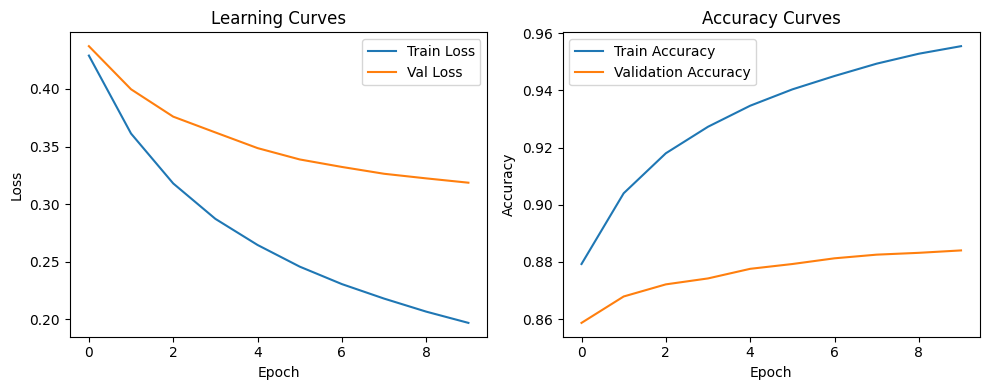

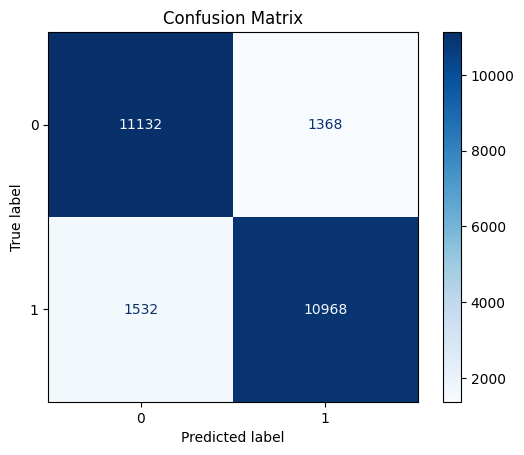

In [ ]:
##### YOUR CODE HERE ######
# Plot learning curves and other diagnostics

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist["train_loss"], label="Train Loss")
plt.plot(hist["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning Curves")

plt.subplot(1,2,2)
plt.plot(hist["train_acc"], label="Train Accuracy")
plt.plot(hist["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.tight_layout()
plt.show()

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

## 2. Word Embeddings for Text Classification

### Introduction to word embeddings

In [ ]:
# Do not need to run this cell, this is an illustration of the type of annotations
# that used to be curated in wordnet
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
statistics = wn.synset("statistics.n.01")
poses = {'n':'noun', 'v':'verb', 's':'adj (s)', 'a':'adj', 'r':'adv'}
hyper = lambda s: s.hypernyms()
list(statistics.closure(hyper))

[nltk_data] Downloading package wordnet to /root/nltk_data...


[Synset('applied_mathematics.n.01'),
 Synset('mathematics.n.01'),
 Synset('science.n.01'),
 Synset('discipline.n.01'),
 Synset('knowledge_domain.n.01'),
 Synset('content.n.05'),
 Synset('cognition.n.01'),
 Synset('psychological_feature.n.01'),
 Synset('abstraction.n.06'),
 Synset('entity.n.01')]

In [ ]:
excerpt = train_texts[0:5]
pprint(excerpt[0][:100])

('This was a very enjoyable film. A humorous, but poignant look at family, and '
 'the obligations that co')


In [ ]:
def tokenize(s):
    s = s.lower()
    s = re.sub(r"[^a-z0-9']+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s.split()

clean = [basic_clean(excerpt[i]) for i in range(5)]
print("Before cleaning:", excerpt[0][:15])
print("After cleaning:", clean[0][:16])
tokens = [tokenize(clean[i]) for i in range(5)]
print("Tokenized and cleaned:", tokens[0][:3])
print("Number of tokens in first doc:", len(tokens[0]))

Before cleaning: This was a very
After cleaning: his was a very e
Tokenized and cleaned: ['his', 'was', 'a']
Number of tokens in first doc: 71


In [ ]:
from collections import Counter
import numpy as np

all_tokens = [t for doc in tokens for t in doc]
vocab = sorted(set(all_tokens))
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

word_to_idx = {w: i for i, w in enumerate(vocab)}

def one_hot_encode_word(word, vocab_size):
    vec = np.zeros(vocab_size, dtype=np.float32)
    vec[word_to_idx[word]] = 1.0
    return vec

seq_matrix = np.stack([one_hot_encode_word(w, vocab_size) for w in tokens[0]])
print("One hot encoded document 0's size:", seq_matrix.shape)

Vocabulary size: 534
One hot encoded document 0's size: (71, 534)


### **Instructions 2a**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import numpy as np

def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    words = sorted(set(w for doc in corpus for w in doc))
    return words, len(words) # sorted distinct tokens, count

def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.

              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".

        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):
                Co-occurence matrix of word counts.
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, n_words = distinct_words(corpus)
    word2ind = {w: i for i, w in enumerate(words)}
    M = np.zeros((n_words, n_words), dtype=np.float64)

    for doc in corpus:
        idx_seq = [word2ind[w] for w in doc if w in word2ind]
        L = len(idx_seq)
        for i in range(L):
            wi = idx_seq[i]
            right_end = min(L, i + window_size + 1)
            for j in range(i + 1, right_end):
                wj = idx_seq[j]
                M[wi, wj] += 1.0
                M[wj, wi] += 1.0

    return M, word2ind

def reduce_to_k_dim(M, k=2, n_iters=10, random_state=42):
    """Reduce a co-occurrence count matrix M (V x V) to (V x k) using TruncatedSVD.

    Returns U * S (i.e., fit_transform output), which is a dense (V x k) matrix.
    """
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    ###### YOUR CODE HERE ######
    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=random_state) # SVD
    M_reduced = svd.fit_transform(M) # Embedding shape: (V, k)
    explained = svd.explained_variance_ratio_.sum() # Variance explained
    print(f"Explained variance (k={k}): {explained:.4f}")
    print("Done.")
    return M_reduced

def plot_embeddings(M_reduced, word2ind, words):
    """Scatter-plot 2D embeddings for a subset of words with labels."""
    assert M_reduced.shape[1] == 2, "M_reduced must be 2D for plotting."

    xs, ys, kept = [], [], []
    for w in words:
        if w in word2ind:
            i = word2ind[w]
            xs.append(M_reduced[i, 0])
            ys.append(M_reduced[i, 1])
            kept.append(w)
        else:
            pass # quietly skip out of vocabulary words

    plt.figure(figsize=(5, 3))
    plt.scatter(xs, ys, s=40)
    for x, y, w in zip(xs, ys, kept):
        plt.text(x + 0.005, y + 0.005, w, fontsize=10)

    plt.title("2D Co-occurrence Embeddings (TruncatedSVD)")
    plt.xlabel("SVD dim 1")
    plt.ylabel("SVD dim 2")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

Running Truncated SVD over 534 words...
Explained variance (k=2): 0.3962
Done.


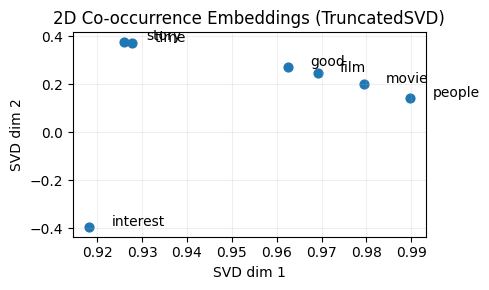

In [ ]:
corpus = tokens # deleted the brackets because it's causing an error
##### YOUR CODE HERE #####
M, word2ind = compute_co_occurrence_matrix(corpus, window_size=4) # build co-occurrence matrix
M_reduced = reduce_to_k_dim(M, k=2) # reduce to 2 dimensions

M_lengths = np.linalg.norm(M_reduced, axis=1, keepdims=True)
M_normalized = M_reduced / np.maximum(M_lengths, 1e-8)

sample_words = ['movie','film','lady','interest','good','time','story', 'sister','people','characters','think']
plot_embeddings(M_normalized, word2ind, sample_words)

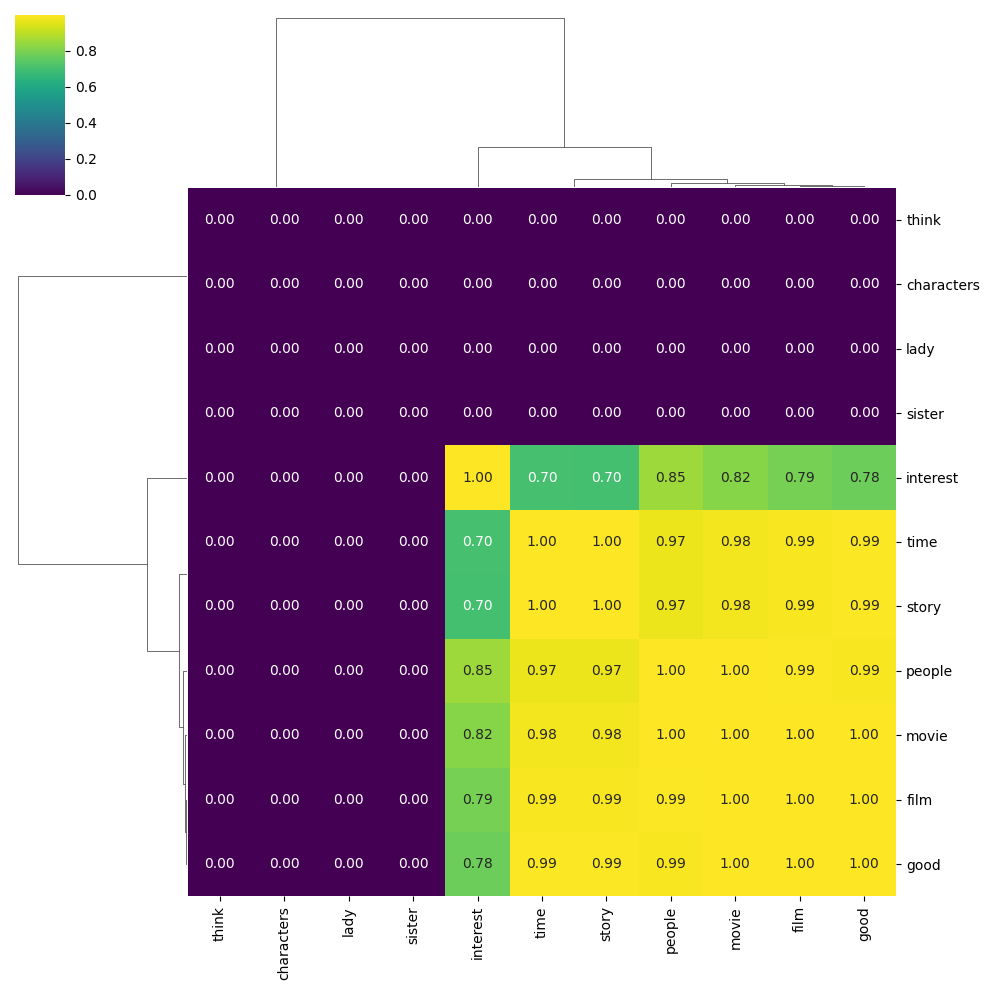

In [ ]:
# Suggest similarity measure
def similarity(w1, w2, M, word2ind, eps=1e-9):
  ##### YOUR CODE HERE #####
  if w1 not in word2ind or w2 not in word2ind:
      return np.nan
  v1 = M[word2ind[w1]]
  v2 = M[word2ind[w2]]
  sim = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2) + eps)
  return sim

def matrix_similarity(list_words, M, word2ind):
  ##### YOUR CODE HERE #####
  n = len(list_words)
  S = np.zeros((n, n))
  for i in range(n):
      for j in range(n):
          S[i, j] = similarity(list_words[i], list_words[j], M, word2ind)
  return S

# Plot the similarity matrix obtained
##### YOUR CODE HERE #####
import seaborn as sns
import pandas as pd

S = matrix_similarity(sample_words, M_normalized, word2ind)
S = np.nan_to_num(S, nan=0.0, posinf=0.0, neginf=0.0)
sns.clustermap(
    pd.DataFrame(S, index=sample_words, columns=sample_words),
    cmap="viridis",
    annot=True,
    fmt=".2f"
)

### **Question 2b**

Running Truncated SVD over 534 words...
Explained variance (k=2): 0.9385
Done.


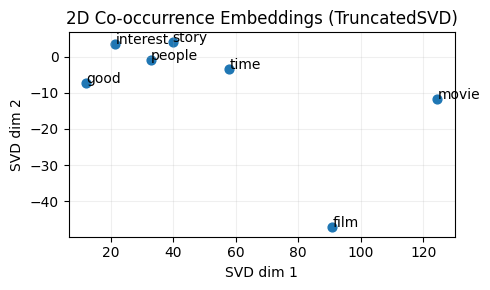

In [ ]:
M, word2ind = compute_co_occurrence_matrix(corpus, window_size=100)
M_reduced = reduce_to_k_dim(M, k=2)
plot_embeddings(M_reduced, word2ind, sample_words)

### **Your answer:**
With a window size of 100, the embeddings become much less informative — most words co-occur with almost all others in each document, so the co-occurrence matrix loses structure. The resulting embedding collapses into a low-variance space where distinctions between words blur. This shows how overly large context windows produce poor-quality embeddings, even though the explained variance increases dramatically from around 0.4 to above 0.9.

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 70.1 MB/s eta 0:00:00


In [ ]:
def load_embedding_model():
    """ Load word2vec Vectors
        Return:
            wv_from_bin: All embeddings
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin
wv_from_bin = load_embedding_model()

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Loaded vocab size 3000000


In [ ]:
print(f'Vector dimensionality: {wv_from_bin.vector_size}')

Vector dimensionality: 300


<Figure size 500x500 with 0 Axes>

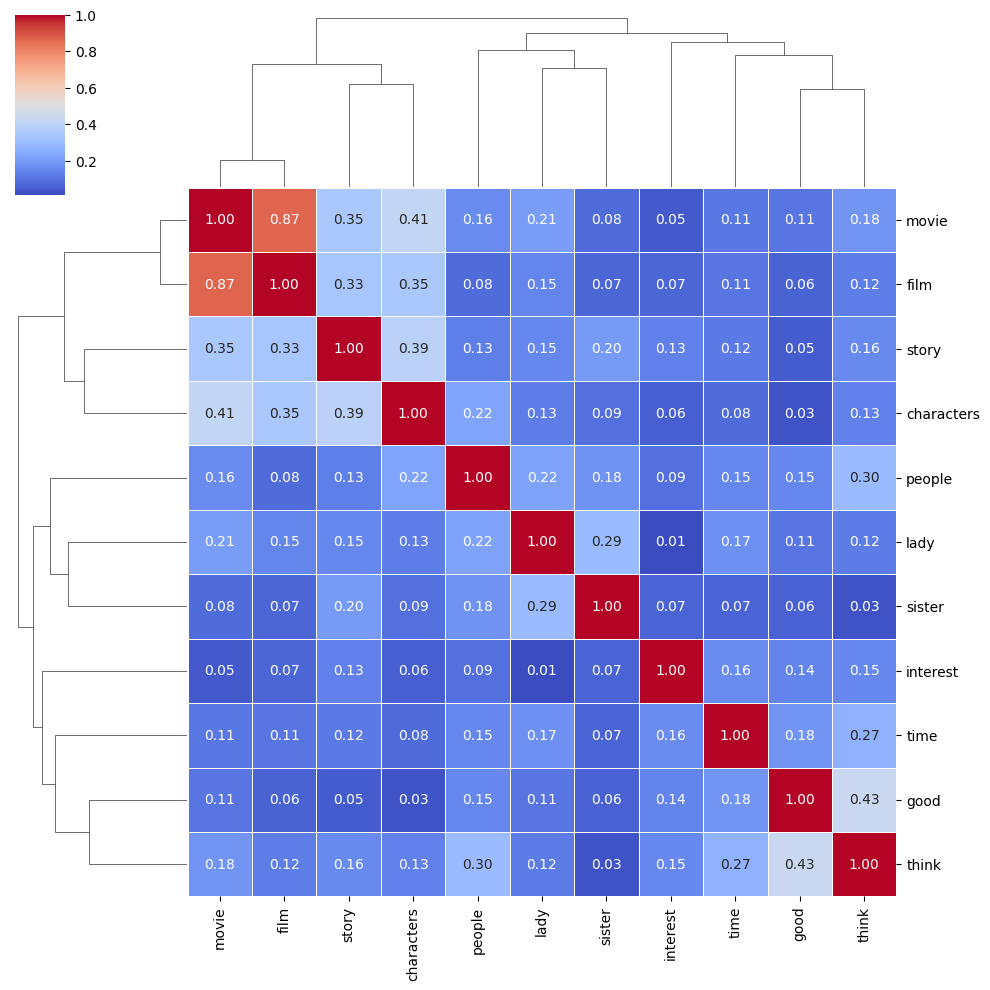

In [ ]:
def w2v_similarity(wv, sample_words):
    kept = []
    for w in sample_words:
      if w in wv:
        kept.append(w)

    normed = getattr(wv, "get_normed_vectors", None)
    if normed is not None:
      idx = [wv.key_to_index[w] if w in wv else None for w in kept]
      vecs = normed()[idx, :]
      similarity = np.clip(vecs @ vecs.T, -1.0, 1.0)
    else:
      print("No normalized vectors")

    return similarity

plt.figure(figsize=(5,5))
sns.clustermap(
    w2v_similarity(wv_from_bin, sample_words),
    xticklabels=sample_words,
    yticklabels=sample_words,
    cmap="coolwarm",        # or "viridis", "magma"
    linewidths=0.5,
    annot=True,
    fmt=".2f"
)

## 3. CNN for text classification

### a. Prepare the Data

## **Instructions & Question 3a**

In [ ]:
# We iterate all the corpus through our cleaning functions and tokenize it
# You can use some of the previously defined functions
#### YOUR CODE HERE ####
train_data = [tokenize(basic_clean(doc)) for doc in train_texts]
test_data = [tokenize(basic_clean(doc)) for doc in test_texts]

In [ ]:
from collections import Counter

def build_vocab(token_docs, max_words=30000, skip_top=0, specials=("<pad>","<oov>")):
    PAD, OOV = specials
    freq = Counter([w for doc in token_docs for w in doc])
    most_common = [w for w,_ in freq.most_common(max_words + skip_top)][skip_top:]
    vocab = [PAD, OOV] + most_common
    word2idx = {w:i for i,w in enumerate(vocab)}
    return vocab, word2idx

vocab, word2idx = build_vocab(train_data)

def build_w2v_embedding_matrix(word2idx, wv, pad_idx=0, oov_idx=1, rand_scale=0.6):
    V = len(word2idx)
    D = wv.vector_size
    emb = np.random.normal(scale=rand_scale, size=(V, D)).astype("float32")
    emb[pad_idx] = 0.0

    found, known_rows = 0, []
    for w, i in word2idx.items():
        if w in wv:
            emb[i] = wv[w]
            found += 1
            if i not in (pad_idx, oov_idx):
                known_rows.append(i)

    if known_rows:
        emb[oov_idx] = emb[known_rows].mean(axis=0)

    print(f"Matched {found}/{V} ({found/V:.1%}) words to pretrained vectors.")
    return torch.tensor(emb)

### Your answer:

`vocab = [PAD, OOV] + most_common` creates the final vocabulary for the model:

- **PAD**: A special token used to pad sequences to a fixed length.
- **OOV**: aka "out-of-vocabulary"; used for words not seen in the training vocabulary.
- **most_common**: The most frequent words from the training corpus.

In [ ]:
emb_matrix = build_w2v_embedding_matrix(word2idx, wv_from_bin)

Matched 22525/30002 (75.1%) words to pretrained vectors.


Documents in class 0: 12500
Documents in class 1: 12500


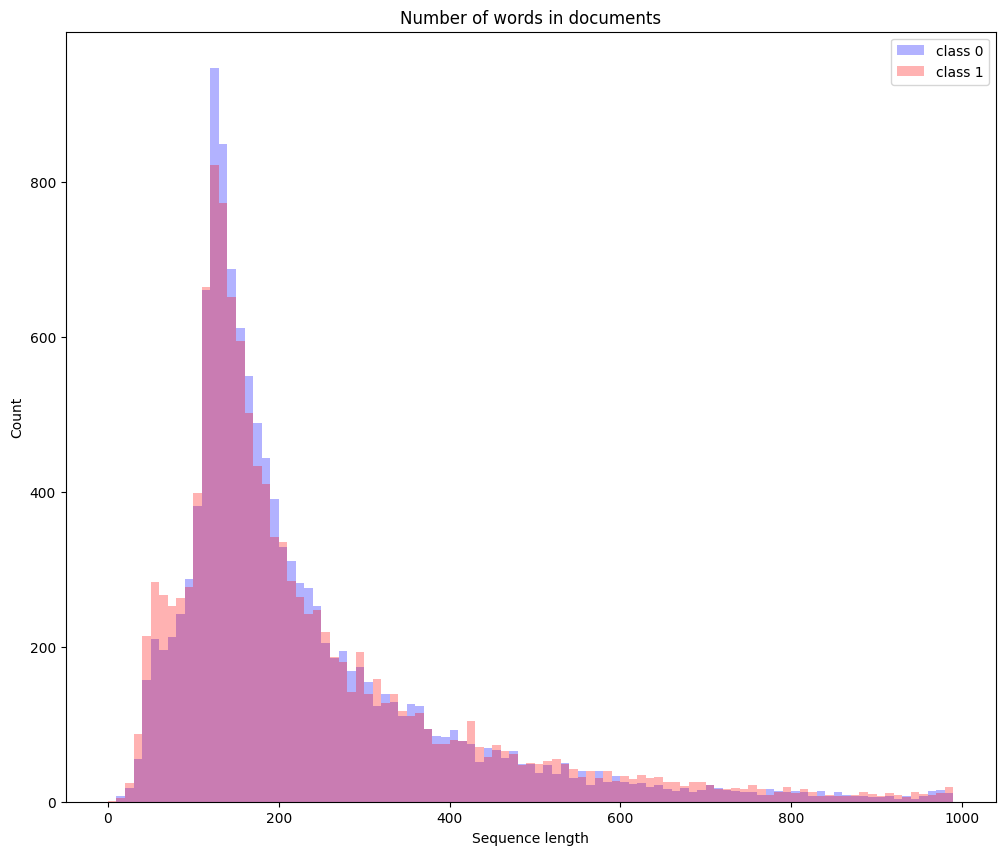

In [ ]:
lens0 = [len(s) for i,s in enumerate(train_data) if train_labels[i] == 0]
lens1 = [len(s) for i,s in enumerate(train_data) if train_labels[i] == 1]

print("Documents in class 0:", len(lens0))
print("Documents in class 1:", len(lens1))

plt.figure(figsize=(12,10))
plt.hist(lens0, bins=range(0, 1000, 10), color="blue", alpha=0.3, label="class 0")
plt.hist(lens1, bins=range(0, 1000, 10), color="red", alpha=0.3, label="class 1")
plt.legend()
plt.title("Number of words in documents")
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.show()

In [ ]:
all_lens = np.array([len(s) for s in train_data])
for p in (90, 95, 98, 99):
    print(f"P{p}: {np.percentile(all_lens, p):.0f}")

# e.g., pick 95th percentile as MAX_LEN:
MAX_LEN = int(np.percentile(all_lens, 95))
print("Chosen MAX_LEN:", MAX_LEN)

# Estimate truncation rate:
trunc_rate = (all_lens > MAX_LEN).mean()
print(f"Truncation rate at MAX_LEN={MAX_LEN}: {trunc_rate*100:.2f}%")

P90: 456
P95: 599
P98: 788
P99: 910
Chosen MAX_LEN: 599
Truncation rate at MAX_LEN=599: 4.99%


In [ ]:
from torch.utils.data import Dataset, DataLoader


def encode(doc, word2idx, oov_idx=1):
    return [word2idx.get(w, oov_idx) for w in doc]

def pad_to_max_len(ids, max_len=600, pad_idx=0):
    ids = ids[:max_len]
    if len(ids) < max_len:
        ids += [pad_idx] * (max_len - len(ids))
    return ids


class TextDataset(Dataset):
  def __init__(self, data, labels, word2idx):
    assert len(data) == len(labels)
    self.X = []
    self.y = []
    for toks, y in zip(data, labels):
        ids = encode(toks, word2idx)
        ids = pad_to_max_len(ids)
        self.X.append(torch.tensor(ids, dtype=torch.long))
        self.y.append(torch.tensor([y], dtype=torch.float32))

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

train_dataloader = DataLoader(TextDataset(train_data, train_labels, word2idx),batch_size=64, shuffle=True)
test_dataloader = DataLoader(TextDataset(test_data, test_labels, word2idx), batch_size=64)

### b. Build the CNN with embedding layer

## **Instructions 3b**

### **Your answer here:**

In this model, the pretrained `word2vec` embeddings are unfrozen, meaning they are trainable. This allows the CNN to fine-tune the embeddings for the IMDB sentiment classification task. Fine-tuning can improve performance by adjusting word vectors to better capture sentiment-relevant features in the dataset. If the embeddings were frozen, they would remain fixed, which can reduce training time and lower the risk of overfitting. Therefore, unfreezing is preferred for larger datasets or when nuances in a task are important, while freezing can be useful for smaller datasets or faster, more stable training.


In [ ]:
# Create the embedding layers, explain whether you choose to freeze the weights are not
##### YOUR CODE HERE #####
embedding = nn.Embedding.from_pretrained(build_w2v_embedding_matrix(word2idx, wv_from_bin),
                                         freeze=False, padding_idx=0)

Matched 22525/30002 (75.1%) words to pretrained vectors.


In [ ]:
# Create the CNN using nn.Sequential
##### YOUR CODE HERE #####

class MultiFilterCNN(nn.Module):
    def __init__(self, embed_dim, num_filters=64, filter_sizes=[3,4,5]):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(embed_dim, num_filters, kernel_size=fs),
                nn.ReLU(),
                nn.AdaptiveMaxPool1d(1)
            )
            for fs in filter_sizes
        ])

    def forward(self, x):
        # x: [B, E, L]
        outputs = [conv(x).squeeze(-1) for conv in self.convs]  # each [B, num_filters]
        return torch.cat(outputs, dim=1)  # [B, num_filters * len(filter_sizes)]

# Helper module to do transpose in nn.Sequential
class Transpose(nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

# Create the CNN using nn.Sequential
model = nn.Sequential(
    embedding,
    nn.Dropout(0.3),         # hopefully reduce overfitting but looks like not :/
    Transpose(),

    MultiFilterCNN(
        embed_dim=embedding.embedding_dim,
        num_filters=64,
        filter_sizes=[3,4,5]
    ),                      # [B, 64*3 = 192]

    nn.Dropout(0.3),
    nn.Linear(192, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1),
    nn.Sigmoid()            # using BCELoss
)


In [ ]:
# Verify that the embedding has selected choice of weight freeze/unfreezing
for name, param in model.named_parameters():
    print(name, param.requires_grad)

0.weight True
3.convs.0.0.weight True
3.convs.0.0.bias True
3.convs.1.0.weight True
3.convs.1.0.bias True
3.convs.2.0.weight True
3.convs.2.0.bias True
5.weight True
5.bias True
8.weight True
8.bias True


### c. Train and evaluate model

### **Instructions 3c**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

##### YOUR CODE HERE ######

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop as usual
def train_epoch(model, dataloader, criterion, optimizer, device=device):
    model.train()
    total_loss, total_correct, total_examples = 0, 0, 0

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device).float().view(-1, 1)   # ensure shape [B,1] and float

        optimizer.zero_grad()
        y_pred = model(X)                      # output already has sigmoid

        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)

        preds = (y_pred > 0.5).long()          # [B,1]
        labels = y.long()                      # [B,1]
        total_correct += (preds == labels).sum().item()
        total_examples += X.size(0)

    return total_loss / total_examples, total_correct / total_examples


# Evaluation as usual
def eval_model(model, dataloader, criterion, device=device):
    model.eval()
    total_loss, total_correct, total_examples = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device).float().view(-1, 1)

            y_pred = model(X)

            loss = criterion(y_pred, y)
            total_loss += loss.item() * X.size(0)

            preds = (y_pred > 0.5).long()
            labels = y.long()

            total_correct += (preds == labels).sum().item()
            total_examples += X.size(0)

            all_preds.extend(preds.cpu().numpy().reshape(-1))
            all_labels.extend(labels.cpu().numpy().reshape(-1))

    avg_loss = total_loss / total_examples
    avg_acc = total_correct / total_examples
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    return avg_loss, avg_acc, cm, report

 10%|█         | 1/10 [00:17<02:39, 17.72s/it]

Epoch 1/10: Train Loss=0.5854, Train Acc=66.83%, Val Loss=0.3625, Val Acc=84.04%


 20%|██        | 2/10 [00:33<02:14, 16.87s/it]

Epoch 2/10: Train Loss=0.3231, Train Acc=86.39%, Val Loss=0.2994, Val Acc=87.41%


 30%|███       | 3/10 [00:50<01:56, 16.64s/it]

Epoch 3/10: Train Loss=0.2230, Train Acc=91.37%, Val Loss=0.3043, Val Acc=87.37%


 40%|████      | 4/10 [01:06<01:39, 16.58s/it]

Epoch 4/10: Train Loss=0.1533, Train Acc=94.32%, Val Loss=0.3646, Val Acc=86.20%


 50%|█████     | 5/10 [01:23<01:23, 16.61s/it]

Epoch 5/10: Train Loss=0.1057, Train Acc=96.20%, Val Loss=0.3679, Val Acc=86.28%


 60%|██████    | 6/10 [01:40<01:06, 16.59s/it]

Epoch 6/10: Train Loss=0.0675, Train Acc=97.68%, Val Loss=0.4469, Val Acc=86.54%


 70%|███████   | 7/10 [01:56<00:49, 16.58s/it]

Epoch 7/10: Train Loss=0.0502, Train Acc=98.24%, Val Loss=0.4458, Val Acc=86.43%


 80%|████████  | 8/10 [02:13<00:33, 16.55s/it]

Epoch 8/10: Train Loss=0.0359, Train Acc=98.77%, Val Loss=0.5526, Val Acc=86.12%


 90%|█████████ | 9/10 [02:29<00:16, 16.51s/it]

Epoch 9/10: Train Loss=0.0322, Train Acc=99.01%, Val Loss=0.6543, Val Acc=85.56%


100%|██████████| 10/10 [02:45<00:00, 16.60s/it]

Epoch 10/10: Train Loss=0.0213, Train Acc=99.23%, Val Loss=0.7890, Val Acc=85.04%


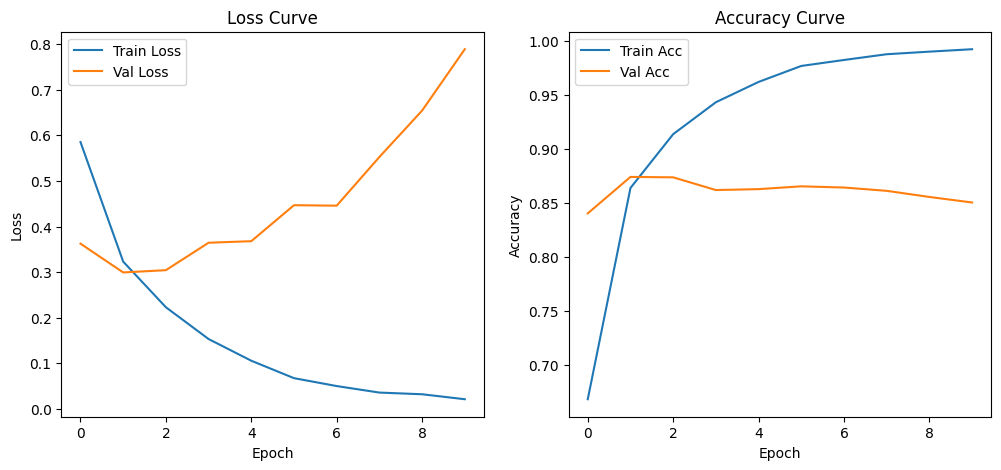

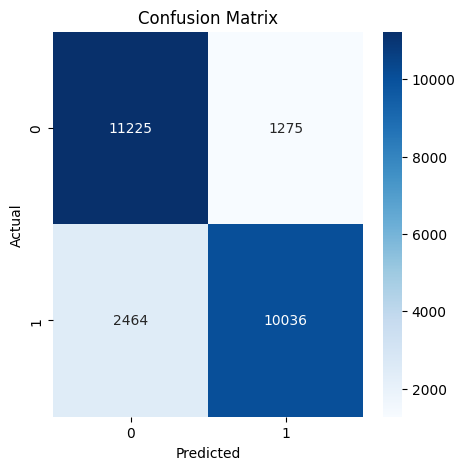

              precision    recall  f1-score   support

           0     0.8200    0.8980    0.8572     12500
           1     0.8873    0.8029    0.8430     12500

    accuracy                         0.8504     25000
   macro avg     0.8536    0.8504    0.8501     25000
weighted avg     0.8536    0.8504    0.8501     25000



In [ ]:
##### YOUR CODE HERE #####

!pip install tqdm
import tqdm

# Plots and outputs of loss, accuracy, and other diagnostics

epochs = 10
hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in tqdm.tqdm(range(epochs)):
    train_loss, train_acc = train_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc, cm, report = eval_model(model, test_dataloader, criterion, device)

    hist["train_loss"].append(train_loss)
    hist["train_acc"].append(train_acc)
    hist["val_loss"].append(val_loss)
    hist["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc*100:.2f}%, Val Loss={val_loss:.4f}, Val Acc={val_acc*100:.2f}%")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist["train_loss"], label="Train Loss")
plt.plot(hist["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist["train_acc"], label="Train Acc")
plt.plot(hist["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()

# Confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(report)

### Question 3d

**Your answer:**

The BOW + Logistic Regression model achieves high validation accuracy (about 88%) and shows minimal overfitting, with training and validation performance closely aligned. In contrast, the Word Embedding + CNN model overfits heavily: training accuracy is very high (about 99%) but validation accuracy drops (about 86%), indicating poor generalization. BOW performs better here due to its simplicity and the clear signal in word counts. To improve the CNN, one could adjust dropout rates, freeze or fine-tune embeddings, change kernel sizes, and tune learning rates.



### Optional

Matched 22525/30002 (75.1%) words to pretrained vectors.


 10%|█         | 1/10 [00:23<03:31, 23.50s/it]

Epoch 1/10: Train Loss=0.6933, Train Acc=49.86%, Val Loss=0.6930, Val Acc=50.33%


 20%|██        | 2/10 [00:47<03:09, 23.63s/it]

Epoch 2/10: Train Loss=0.6898, Train Acc=50.60%, Val Loss=0.6953, Val Acc=50.45%


 30%|███       | 3/10 [01:10<02:44, 23.46s/it]

Epoch 3/10: Train Loss=0.6744, Train Acc=51.77%, Val Loss=0.7081, Val Acc=50.06%


 40%|████      | 4/10 [01:33<02:20, 23.40s/it]

Epoch 4/10: Train Loss=0.6624, Train Acc=52.51%, Val Loss=0.7150, Val Acc=50.43%


 50%|█████     | 5/10 [01:57<01:57, 23.57s/it]

Epoch 5/10: Train Loss=0.6597, Train Acc=52.90%, Val Loss=0.7137, Val Acc=50.00%


 60%|██████    | 6/10 [02:21<01:34, 23.61s/it]

Epoch 6/10: Train Loss=0.6591, Train Acc=53.12%, Val Loss=0.7330, Val Acc=49.97%


 70%|███████   | 7/10 [02:44<01:10, 23.60s/it]

Epoch 7/10: Train Loss=0.6579, Train Acc=52.70%, Val Loss=0.7439, Val Acc=50.44%


 80%|████████  | 8/10 [03:08<00:47, 23.57s/it]

Epoch 8/10: Train Loss=0.6573, Train Acc=52.08%, Val Loss=0.7522, Val Acc=50.45%


 90%|█████████ | 9/10 [03:32<00:23, 23.58s/it]

Epoch 9/10: Train Loss=0.6566, Train Acc=52.92%, Val Loss=0.7465, Val Acc=50.03%


100%|██████████| 10/10 [03:55<00:00, 23.58s/it]

Epoch 10/10: Train Loss=0.6566, Train Acc=53.02%, Val Loss=0.7625, Val Acc=50.32%


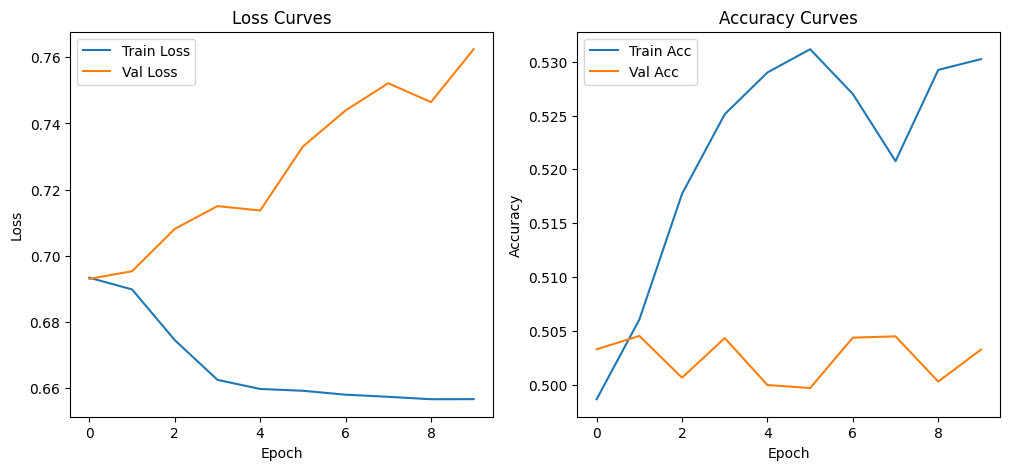

Confusion Matrix:
 [[12034   466]
 [11953   547]]

Classification Report:
               precision    recall  f1-score   support

         0.0     0.5017    0.9627    0.6596     12500
         1.0     0.5400    0.0438    0.0810     12500

    accuracy                         0.5032     25000
   macro avg     0.5208    0.5032    0.3703     25000
weighted avg     0.5208    0.5032    0.3703     25000



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import tqdm
from sklearn.metrics import confusion_matrix, classification_report

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# LSTM model
class LSTMTextClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, num_layers=1, bidirectional=True, dropout=0.2):
        super().__init__()
        V, D = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=0)
        self.lstm = nn.LSTM(
            input_size=D,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        emb = self.embedding(x)               # [B, L] -> [B, L, D]
        lstm_out, _ = self.lstm(emb)         # [B, L, hidden*directions]
        lstm_last = lstm_out[:, -1, :]       # last timestep [B, hidden*directions]
        out = self.dropout(lstm_last)
        out = self.fc(out)
        out = self.sigmoid(out)              # [B,1]
        return out

# Build embedding matrix
embedding_matrix = build_w2v_embedding_matrix(word2idx, wv_from_bin)
embedding_matrix = embedding_matrix.to(device)

# Initialize model
model = LSTMTextClassifier(embedding_matrix, hidden_dim=128, num_layers=1, bidirectional=True, dropout=0.2)
model.to(device)

# Criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop as usual
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct, total_examples = 0, 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device).float()   # [B,1]
        optimizer.zero_grad()
        y_pred = model(X)                           # [B,1]
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        preds = (y_pred > 0.5).long()
        total_correct += (preds == y.long()).sum().item()
        total_examples += X.size(0)
    return total_loss / total_examples, total_correct / total_examples

# Eval loop as usual
def eval_model(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct, total_examples = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).float()
            y_pred = model(X)
            loss = criterion(y_pred, y)

            total_loss += loss.item() * X.size(0)
            preds = (y_pred > 0.5).long()
            total_correct += (preds == y.long()).sum().item()
            total_examples += X.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / total_examples
    avg_acc = total_correct / total_examples
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)
    return avg_loss, avg_acc, cm, report

# Training loop as usual
epochs = 10
hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in tqdm.tqdm(range(epochs)):
    train_loss, train_acc = train_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc, cm, report = eval_model(model, test_dataloader, criterion, device)

    hist["train_loss"].append(train_loss)
    hist["train_acc"].append(train_acc)
    hist["val_loss"].append(val_loss)
    hist["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc*100:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc*100:.2f}%")

# Plot learning curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist["train_loss"], label="Train Loss")
plt.plot(hist["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(hist["train_acc"], label="Train Acc")
plt.plot(hist["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curves")
plt.show()

# Print confusion matrix
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)